In [7]:
# Imports
import sys
import json
import torch
import numpy as np
import pandas as pd
import datasets
from scipy.stats import entropy
from transformers import AutoTokenizer, DataCollatorWithPadding
import matplotlib.pyplot as plt

In [8]:
from datasets.dataset_dict import DatasetDict, Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from pytorch_lightning import LightningModule
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
from torch.nn.functional import softmax

In [9]:
sys.path.append("/home/meissner/shortcut-pruning")
from src.models.hf_model import SequenceClassificationTransformer

In [10]:
mnli = datasets.load_dataset("glue", "mnli")

Reusing dataset glue (/home/meissner/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/5 [00:00<?, ?it/s]

In [12]:
def get_mnli_preds(checkpoint_path, subset="validation_matched", batch_size=256, max_length=128):
    dataset = datasets.load_dataset("glue", "mnli").rename_column("label", "labels")
    sent1 = "premise"
    sent2 = "hypothesis"

    model = SequenceClassificationTransformer.load_from_checkpoint(checkpoint_path, use_bias_probs=False)
    tokenizer = AutoTokenizer.from_pretrained(model.hparams.huggingface_model)

    def preprocess_func(examples: dict):
        args = (examples[sent1], examples[sent2])
        result = tokenizer(*args, max_length=max_length, truncation=True)
        return result

    dataset = dataset.map(preprocess_func, batched=True, num_proc=4)

    dataset.set_format(
        "torch",
        columns=[
            "input_ids",
            "attention_mask",
            "token_type_ids",
            "labels",
            "idx",
        ],
    )

    dataloader = DataLoader(
        dataset[subset],
        batch_size=batch_size,
        shuffle=False,
        collate_fn=DataCollatorWithPadding(tokenizer=tokenizer)
    )

    model.eval()
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)

    predictions = []
    for idx, batch in enumerate(tqdm(dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            logits, preds = model(batch)
            soft_preds = softmax(logits, dim=1).detach().cpu().tolist()
            idxs = batch["idx"].detach().cpu().tolist()
            for idx, soft_pred in zip(idxs, soft_preds):
                predictions.append(soft_pred)
                
    return np.array(predictions)

In [13]:
base_path = "/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/undertrain_mnli_epoch_comparison/weak/multiruns/2022-05-09/19-36-45/"
epoch_1_nums = [0, 5, 10]
epoch_2_nums = [1, 6, 11]
epoch_3_nums = [2, 7, 12]
epoch_4_nums = [3, 8, 13]
epoch_5_nums = [4, 9, 14]

In [14]:
val_preds_per_epoch = []
for epoch_nums in (epoch_1_nums, epoch_2_nums, epoch_3_nums, epoch_4_nums, epoch_5_nums):
    epoch_preds = []
    for num in epoch_nums:
        fullpath = base_path + str(num) + "/checkpoints/last.ckpt"
        epoch_preds.append(get_mnli_preds(fullpath, subset="validation_matched"))
    val_preds_per_epoch.append(epoch_preds)
val_preds_per_epoch = np.array(val_preds_per_epoch)

Reusing dataset glue (/home/meissner/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Loading cached processed dataset at /home/meissner/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da60

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Loading cached processed dataset at /home/meissner/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da60

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Loading cached processed dataset at /home/meissner/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da60

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Loading cached processed dataset at /home/meissner/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da60

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Loading cached processed dataset at /home/meissner/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da60

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Loading cached processed dataset at /home/meissner/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da60

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Loading cached processed dataset at /home/meissner/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da60

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Loading cached processed dataset at /home/meissner/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da60

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Loading cached processed dataset at /home/meissner/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da60

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Loading cached processed dataset at /home/meissner/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da60

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Loading cached processed dataset at /home/meissner/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da60

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Loading cached processed dataset at /home/meissner/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da60

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Loading cached processed dataset at /home/meissner/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da60

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Loading cached processed dataset at /home/meissner/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da60

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Loading cached processed dataset at /home/meissner/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da60

In [15]:
# Shape check
# (epochs, seeds, samples, classes)
# (compare, median_reduce(ensemble), mean_reduce, argmax_reduce)
val_preds_per_epoch.shape

(5, 3, 9815, 3)

In [16]:
# Median-ensemble
array = np.median(np.array(val_preds_per_epoch), axis=1)
weak_val_median_array = array / array.sum(axis=-1, keepdims=True)

In [18]:
def load_probs(path):
    with open(path, "r") as _file:
        probs = json.load(_file)
    return probs

# Load median train preds
basepath = "/home/meissner/shortcut-pruning/data/weak_models/ensembles/median/epoch-comparison/undertrain-mnli-epoch-comparison-"
weak_train_median_array = np.array([list(load_probs(basepath + str(i) + ".json").values()) for i in range(1,6)])

In [19]:
# Shape check
# (epochs, samples, classes)
# (compare, mean_reduce, argmax_reduce)
weak_val_median_array.shape, weak_train_median_array.shape

((5, 9815, 3), (5, 392702, 3))

In [20]:
with open("/home/meissner/shortcut-pruning/data/subsets/mnli_negation_indices.json") as _file:
    negation_indices = json.load(_file)
with open("/home/meissner/shortcut-pruning/data/subsets/mnli_lex_overlap_indices.json") as _file:
    overlap_indices = json.load(_file)

In [21]:
train_labels, val_labels = np.array(mnli["train"]["label"]), np.array(mnli["validation_matched"]["label"])

In [22]:
def evaluate_subset(predictions, targets, cont_indices, ent_indices):
    all_indices = cont_indices + ent_indices
    cont_acc = np.mean(predictions[cont_indices] == targets[cont_indices])
    ent_acc = np.mean(predictions[ent_indices] == targets[ent_indices])
    all_acc = np.mean(predictions[all_indices] == targets[all_indices])
    return cont_acc, ent_acc, all_acc

In [23]:
# Load debiased model preds too
basepath = "/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/undertrain_mnli_epoch_comparison/debias_median/multiruns/2022-05-10/17-33-45/"

In [24]:
paths = [
    "/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/undertrain_mnli_epoch_comparison/debias_median/multiruns/2022-05-10/17-33-45/1",
    "/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/undertrain_mnli_epoch_comparison/debias_median/multiruns/2022-05-10/17-33-45/0",
    "/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/undertrain_mnli_epoch_comparison/debias_median/multiruns/2022-05-10/15-57-44/1",
    "/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/undertrain_mnli_epoch_comparison/debias_median/multiruns/2022-05-10/15-57-44/0",
    "/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/undertrain_mnli_epoch_comparison/debias_median/multiruns/2022-05-10/14-22-52/1",
    "/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/undertrain_mnli_epoch_comparison/debias_median/multiruns/2022-05-10/14-22-52/0",
    "/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/undertrain_mnli_epoch_comparison/debias_median/multiruns/2022-05-10/12-48-00/1",
    "/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/undertrain_mnli_epoch_comparison/debias_median/multiruns/2022-05-10/12-48-00/0",
    "/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/undertrain_mnli_epoch_comparison/debias_median/multiruns/2022-05-10/11-12-08/1",
    "/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/undertrain_mnli_epoch_comparison/debias_median/multiruns/2022-05-10/11-12-08/0",
]

In [25]:
val_preds_per_epoch = []
counter = 0
for epoch in (5, 4, 3, 2, 1):
    epoch_preds = []
    for seed in (10, 11):
        fullpath = paths[counter] + "/checkpoints/last.ckpt"
        epoch_preds.append(get_mnli_preds(fullpath, subset="validation_matched"))
        counter += 1
    val_preds_per_epoch.append(epoch_preds)
debias_val_median_array = np.array(list(reversed(val_preds_per_epoch)))

Reusing dataset glue (/home/meissner/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Loading cached processed dataset at /home/meissner/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da60

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Loading cached processed dataset at /home/meissner/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da60

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Loading cached processed dataset at /home/meissner/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da60

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Loading cached processed dataset at /home/meissner/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da60

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Loading cached processed dataset at /home/meissner/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da60

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Loading cached processed dataset at /home/meissner/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da60

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Loading cached processed dataset at /home/meissner/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da60

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Loading cached processed dataset at /home/meissner/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da60

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Loading cached processed dataset at /home/meissner/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da60

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Loading cached processed dataset at /home/meissner/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da60

In [26]:
debias_val_median_array.shape

(5, 2, 9815, 3)

## Negation Subsets
Contradiction is the bias subset, Entailment is the anti-bias subset.

In [27]:
train_bools = np.argmax(weak_train_median_array, axis=-1) == np.expand_dims(train_labels, axis=0)
train_cont_accs = train_bools[:, negation_indices["train_conts"]].mean(axis=-1)
train_ent_accs = train_bools[:, negation_indices["train_ents"]].mean(axis=-1)
train_cont_accs, train_ent_accs

(array([0.36898096, 0.74194129, 0.84076548, 0.84634458, 0.83660614]),
 array([0.55664541, 0.57639663, 0.54951179, 0.60506487, 0.6520576 ]))

In [28]:
val_bools = np.argmax(weak_val_median_array, axis=-1) == np.expand_dims(val_labels, axis=0)
val_cont_accs = val_bools[:, negation_indices["val_m_conts"]].mean(axis=-1)
val_ent_accs = val_bools[:, negation_indices["val_m_ents"]].mean(axis=-1)
val_cont_accs, val_ent_accs

(array([0.32917706, 0.72069825, 0.83873649, 0.83873649, 0.82793017]),
 array([0.55647841, 0.57142857, 0.55647841, 0.589701  , 0.62624585]))

In [29]:
debias_val_bools = np.argmax(debias_val_median_array, axis=-1) == np.expand_dims(val_labels, axis=(0, 1))
debias_val_cont_accs = debias_val_bools[:, :, negation_indices["val_m_conts"]].mean(axis=(-1, -2))
debias_val_ent_accs = debias_val_bools[:, :, negation_indices["val_m_ents"]].mean(axis=(-1, -2))
debias_val_cont_accs, debias_val_ent_accs

(array([0.91604323, 0.91812136, 0.90689942, 0.89817124, 0.88653367]),
 array([0.79817276, 0.7923588 , 0.7782392 , 0.77076412, 0.73671096]))

In [30]:
entropy_array = np.apply_along_axis(entropy, axis=-1, arr=weak_train_median_array).mean(axis=-1)

In [31]:
entropy

<function scipy.stats._entropy.entropy(pk, qk=None, base=None, axis=0)>

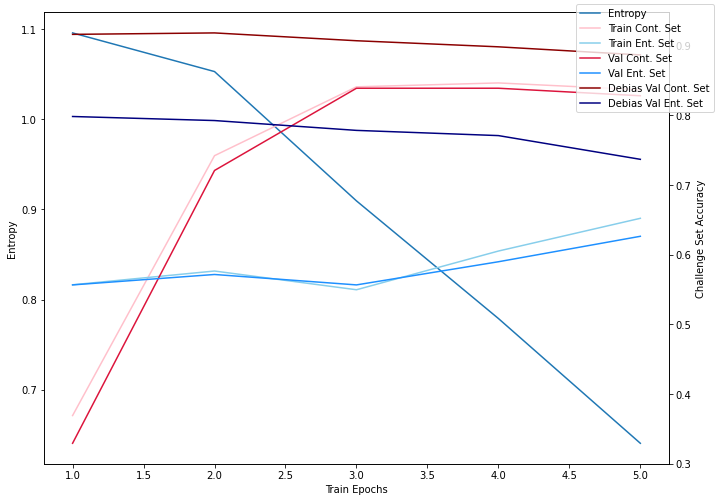

In [32]:
fig, ax1 = plt.subplots(figsize=(10, 7))
epochs = range(1,6)

ax1.set_xlabel("Train Epochs")
ax1.set_ylabel("Entropy")
ax1.plot(epochs, entropy_array, label="Entropy")
ax2 = ax1.twinx()
ax2.set_ylabel('Challenge Set Accuracy')
ax2.plot(epochs, train_cont_accs, label="Train Cont. Set", color="pink")
ax2.plot(epochs, train_ent_accs, label="Train Ent. Set", color="skyblue")
ax2.plot(epochs, val_cont_accs, label="Val Cont. Set", color="crimson")
ax2.plot(epochs, val_ent_accs, label="Val Ent. Set", color="dodgerblue")
ax2.plot(epochs, debias_val_cont_accs, label="Debias Val Cont. Set", color="darkred")
ax2.plot(epochs, debias_val_ent_accs, label="Debias Val Ent. Set", color="navy")

# fig.legend(loc="lower center", bbox_to_anchor=(0.5, 0.15))
fig.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Lexical Overlap Subsets
Entailment is the bias subset, Contradiction is the anti-bias subset.

In [33]:
train_bools = np.argmax(weak_train_median_array, axis=-1) == np.expand_dims(train_labels, axis=0)
train_cont_accs = train_bools[:, overlap_indices["train_conts"]].mean(axis=-1)
train_ent_accs = train_bools[:, overlap_indices["train_ents"]].mean(axis=-1)
train_cont_accs, train_ent_accs

(array([0.00595238, 0.02579365, 0.24801587, 0.30753968, 0.32936508]),
 array([0.9823844 , 0.99842718, 0.99842718, 0.99874174, 0.99905631]))

In [34]:
val_bools = np.argmax(weak_val_median_array, axis=-1) == np.expand_dims(val_labels, axis=0)
val_cont_accs = val_bools[:, overlap_indices["val_m_conts"]].mean(axis=-1)
val_ent_accs = val_bools[:, overlap_indices["val_m_ents"]].mean(axis=-1)
val_cont_accs, val_ent_accs

(array([0.        , 0.        , 0.27777778, 0.30555556, 0.33333333]),
 array([0.95138889, 0.99305556, 1.        , 1.        , 1.        ]))

In [35]:
debias_val_bools = np.argmax(debias_val_median_array, axis=-1) == np.expand_dims(val_labels, axis=(0, 1))
debias_val_cont_accs = debias_val_bools[:, :, overlap_indices["val_m_conts"]].mean(axis=(-1, -2))
debias_val_ent_accs = debias_val_bools[:, :, overlap_indices["val_m_ents"]].mean(axis=(-1, -2))
debias_val_cont_accs, debias_val_ent_accs

(array([0.875     , 0.88888889, 0.91666667, 0.94444444, 0.94444444]),
 array([0.98263889, 0.97916667, 0.94097222, 0.93402778, 0.92013889]))

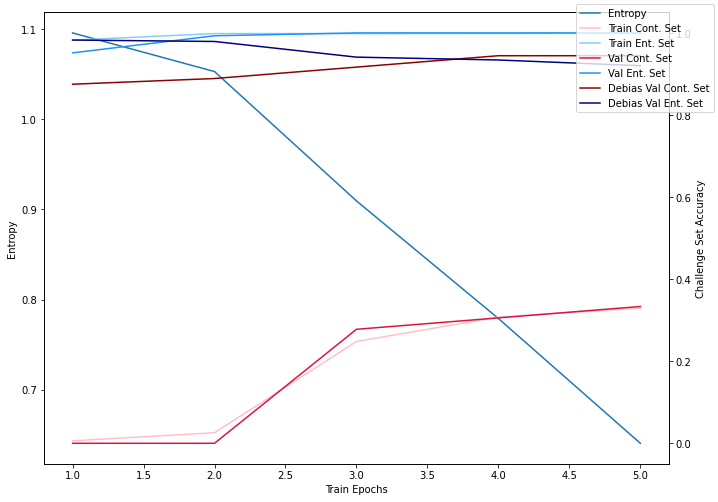

In [36]:
fig, ax1 = plt.subplots(figsize=(10, 7))
epochs = range(1,6)

ax1.set_xlabel("Train Epochs")
ax1.set_ylabel("Entropy")
ax1.plot(epochs, entropy_array, label="Entropy")
ax2 = ax1.twinx()
ax2.set_ylabel('Challenge Set Accuracy')
ax2.plot(epochs, train_cont_accs, label="Train Cont. Set", color="pink")
ax2.plot(epochs, train_ent_accs, label="Train Ent. Set", color="skyblue")
ax2.plot(epochs, val_cont_accs, label="Val Cont. Set", color="crimson")
ax2.plot(epochs, val_ent_accs, label="Val Ent. Set", color="dodgerblue")
ax2.plot(epochs, debias_val_cont_accs, label="Debias Val Cont. Set", color="darkred")
ax2.plot(epochs, debias_val_ent_accs, label="Debias Val Ent. Set", color="navy")

# fig.legend(loc="center left", bbox_to_anchor=(0, 0))
fig.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()